In [1]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pathlib import Path
import pandas as pd
import seaborn as sns
from easydict import EasyDict as edict

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict as ddict
from pprint import pprint

In [3]:
def sortdir(f):
    num = f.name.split("_")[-2].split("p")[-1]
    num = int(num)
    return  num

def sortf(f):
    num = f.name.split(".")[0]
    num = int(num)
    return num

In [4]:
def load_pkl(f):
    with open(f, "rb") as fi:
        data = pickle.load(fi)
    return data

## To obtaining simple format file

In [5]:
def parse_sresult(datum):
    res = {
        "JEF"  : datum["jef"]["theta"],
        "FULL": datum["full"]["theta"],
        "UIPD" : datum["UIPD"]["thetah"],
        "UIPJS": datum["UIPJS"]["thetah"],
        "NPP"  : datum["NPP"]["thetah"],
        "LCP"  : datum["LCP"]["thetah"],
        "rMAP" : datum["rMAP"]["thetaP"]
    }
    return res

def save_data(cdir):
    files = list(cdir.glob("*.pkl"))
    files = sorted(files, key=sortf, reverse=False)
    retres = {
        "JEF":[],
        "FULL":[],
        "LCP":[],
        "NPP":[],
        "UIPJS":[],
        "UIPD":[],
        "rMAP":[]
    }
    for fil in tqdm(files):
        datum = load_pkl(fil)
        simdatum = parse_sresult(datum)
        retres["JEF"].append(simdatum["JEF"])
        retres["FULL"].append(simdatum["FULL"])
        retres["UIPD"].append(simdatum["UIPD"])
        retres["UIPJS"].append(simdatum["UIPJS"])
        retres["NPP"].append(simdatum["NPP"])
        retres["LCP"].append(simdatum["LCP"])
        retres["rMAP"].append(simdatum["rMAP"])
    return retres

### Obain the folders

In [6]:
def is_true(theta0, bs):
    low, up = bs
    return (theta0 > low) and (theta0 < up)


def rejrate(theta0, data, theta):
    reslist = [is_true(theta0, bs=[np.quantile(dat, q=theta), np.quantile(dat, q=1-theta)]) for dat in data] 
    return 1 - np.mean(reslist)


def getRatio(theta0, data):
    p1 = np.mean(data<=theta0)
    p2 = np.mean(data>theta0)
    res = np.min([p1, p2])
    return res



def getQuantile(theta0, data, alp=0.05):
    res = [getRatio(theta0, data=dat) for dat in data]
    return np.quantile(res, q=alp)

### Get the CV

In [7]:
n = 120

root = Path(f"./results/")
n = 120
fls = root.glob(f"SimBiostatR1*_n{n}.pkl")
fls = list(fls)
fls = sorted(fls, key=sortdir)

In [9]:
sizes = ddict(list)
for cfl, theta0 in zip(fls, idxs):
    cleanData = load_pkl(cfl)
    for key, dat in cleanData.items():
        sizes[key].append(rejrate(theta0, dat, 0.025))

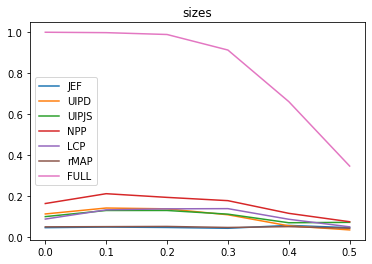

In [86]:
thetas = idxs
low = 0
up = 6
plt.title("sizes")
##plt.ylim([0, 0.05])
plt.plot(thetas[low:up], sizes["JEF"][low:up], "-", label="JEF")
plt.plot(thetas[low:up], sizes["UIPD"][low:up], label="UIPD")
plt.plot(thetas[low:up], sizes["UIPJS"][low:up], label="UIPJS")
plt.plot(thetas[low:up], sizes["NPP"][low:up], label="NPP")
plt.plot(thetas[low:up], sizes["LCP"][low:up], label="LCP")
plt.plot(thetas[low:up], sizes["rMAP"][low:up], label="rMAP")
plt.plot(thetas[low:up], sizes["FULL"][low:up], label="FULL")
plt.legend()

In [77]:
theta0 = 0
idxs = np.array([sortdir(d) for d in fls])/100
idxs = list(np.sort(idxs))
cfl = fls[idxs.index(theta0)]

In [78]:
CVqs = ddict(float)
Alphas = ddict(float)
Alphas95 = ddict(float)

In [79]:
cleanData = load_pkl(cfl)
alps = {
    "JEF": 0.05 - 1e-3,
    "FULL": 0.05,
    "LCP": 0.05 - 1e-3,
    "UIPJS": 0.05 - 1e-3,
    "UIPD": 0.05 - 5e-4,
    "NPP": 0.05 - 5e-4,
    "rMAP": 0.05
}
for key, dat in cleanData.items():
    CVqs[key] = getQuantile(theta0, data=dat, alp=alps[key])
    Alphas[key] = rejrate(theta0, dat, CVqs[key])
    Alphas95[key] = rejrate(theta0, dat, 0.025)
print("Sizes")
for key, v in Alphas.items():
    print(f"{key:<10}: {v:.3f}")


Sizes
JEF       : 0.050
FULL      : 0.962
LCP       : 0.050
NPP       : 0.051
UIPJS     : 0.049
UIPD      : 0.050
rMAP      : 0.051


In [80]:
CVqs

defaultdict(float,
            {'JEF': 0.0264902,
             'FULL': 0.0,
             'LCP': 0.012625500000000001,
             'NPP': 0.00455,
             'UIPJS': 0.010237750000000002,
             'UIPD': 0.008912625000000002,
             'rMAP': 0.025580000000000002})

## Get the powers

In [81]:
Powers = ddict(list)
Powers95 = ddict(list)

In [82]:
for cfl, theta in zip(fls, idxs):
    Powers["theta"].append(theta)
    Powers95["theta"].append(theta)
    datah1 = load_pkl(cfl)
    print("=="*30)
    for key, dat in datah1.items():
        print(f"Current is method {key} in file {cfl.name}!")
        Powers[key].append(rejrate(theta0, dat, CVqs[key]))
        Powers95[key].append(rejrate(theta0, dat, 0.025))

Current is method JEF in file SimBiostatR1_p0_n120.pkl!
Current is method FULL in file SimBiostatR1_p0_n120.pkl!
Current is method LCP in file SimBiostatR1_p0_n120.pkl!
Current is method NPP in file SimBiostatR1_p0_n120.pkl!
Current is method UIPJS in file SimBiostatR1_p0_n120.pkl!
Current is method UIPD in file SimBiostatR1_p0_n120.pkl!
Current is method rMAP in file SimBiostatR1_p0_n120.pkl!
Current is method JEF in file SimBiostatR1_p10_n120.pkl!
Current is method FULL in file SimBiostatR1_p10_n120.pkl!
Current is method LCP in file SimBiostatR1_p10_n120.pkl!
Current is method NPP in file SimBiostatR1_p10_n120.pkl!
Current is method UIPJS in file SimBiostatR1_p10_n120.pkl!
Current is method UIPD in file SimBiostatR1_p10_n120.pkl!
Current is method rMAP in file SimBiostatR1_p10_n120.pkl!
Current is method JEF in file SimBiostatR1_p20_n120.pkl!
Current is method FULL in file SimBiostatR1_p20_n120.pkl!
Current is method LCP in file SimBiostatR1_p20_n120.pkl!
Current is method NPP in fi

In [83]:
Powers = pd.DataFrame(Powers)
print(Powers)
print(f"Powers")
print(Powers.drop(columns=["theta"]).mean(axis=0))
print("Sizes")
for key, v in Alphas.items():
    print(f"{key:<10}: {v:.3f}")

    theta    JEF   FULL    LCP    NPP  UIPJS   UIPD   rMAP
0     0.0  0.050  0.962  0.050  0.051  0.049  0.050  0.051
1     0.1  0.220  0.995  0.283  0.320  0.298  0.313  0.274
2     0.2  0.632  1.000  0.691  0.736  0.720  0.736  0.704
3     0.3  0.909  1.000  0.935  0.955  0.948  0.951  0.945
4     0.4  0.983  1.000  0.990  0.990  0.990  0.991  0.992
5     0.5  1.000  1.000  1.000  1.000  1.000  1.000  1.000
6     0.6  1.000  1.000  1.000  1.000  1.000  1.000  1.000
7     0.7  1.000  1.000  1.000  1.000  1.000  1.000  1.000
8     0.8  1.000  1.000  1.000  1.000  1.000  1.000  1.000
9     0.9  1.000  1.000  1.000  1.000  1.000  1.000  1.000
10    1.0  1.000  1.000  1.000  1.000  1.000  1.000  1.000
Powers
JEF      0.799455
FULL     0.996091
LCP      0.813545
NPP      0.822909
UIPJS    0.818636
UIPD     0.821909
rMAP     0.815091
dtype: float64
Sizes
JEF       : 0.050
FULL      : 0.962
LCP       : 0.050
NPP       : 0.051
UIPJS     : 0.049
UIPD      : 0.050
rMAP      : 0.051


In [87]:
Powers95 = pd.DataFrame(Powers95)
print(Powers95)
print(f"Powers95")
print(Powers95.drop(columns=["theta"]).mean(axis=0))
print("Sizes")
for key, v in Alphas95.items():
    print(f"{key:<10}: {v:.3f}")

    theta    JEF  FULL    LCP    NPP  UIPJS   UIPD   rMAP
0     0.0  0.045   1.0  0.087  0.163  0.099  0.112  0.049
1     0.1  0.212   1.0  0.367  0.558  0.413  0.456  0.272
2     0.2  0.614   1.0  0.779  0.868  0.818  0.833  0.703
3     0.3  0.905   1.0  0.964  0.991  0.977  0.981  0.944
4     0.4  0.983   1.0  0.992  0.999  0.995  0.997  0.992
5     0.5  1.000   1.0  1.000  1.000  1.000  1.000  1.000
6     0.6  1.000   1.0  1.000  1.000  1.000  1.000  1.000
7     0.7  1.000   1.0  1.000  1.000  1.000  1.000  1.000
8     0.8  1.000   1.0  1.000  1.000  1.000  1.000  1.000
9     0.9  1.000   1.0  1.000  1.000  1.000  1.000  1.000
10    1.0  1.000   1.0  1.000  1.000  1.000  1.000  1.000
Powers95
JEF      0.796273
FULL     1.000000
LCP      0.835364
NPP      0.870818
UIPJS    0.845636
UIPD     0.852636
rMAP     0.814545
dtype: float64
Sizes
JEF       : 0.045
FULL      : 1.000
LCP       : 0.087
NPP       : 0.163
UIPJS     : 0.099
UIPD      : 0.112
rMAP      : 0.049


In [47]:
alps = {
    "JEF": 0.05 - 1e-3,
    "FULL": 0.05,
    "LCP": 0.05 - 1e-3,
    "UIPJS": 0.05 - 1e-3,
    "UIPD": 0.05 - 5e-4,
    "NPP": 0.05 - 5e-4,
    "rMAP": 0.05
}



In [58]:
idxs

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [59]:
fls

[PosixPath('results/SimBiostatR1_p0_n120.pkl'),
 PosixPath('results/SimBiostatR1_p10_n120.pkl'),
 PosixPath('results/SimBiostatR1_p20_n120.pkl'),
 PosixPath('results/SimBiostatR1_p30_n120.pkl'),
 PosixPath('results/SimBiostatR1_p40_n120.pkl'),
 PosixPath('results/SimBiostatR1_p50_n120.pkl'),
 PosixPath('results/SimBiostatR1_p60_n120.pkl'),
 PosixPath('results/SimBiostatR1_p70_n120.pkl'),
 PosixPath('results/SimBiostatR1_p80_n120.pkl'),
 PosixPath('results/SimBiostatR1_p90_n120.pkl'),
 PosixPath('results/SimBiostatR1_p100_n120.pkl')]

In [67]:
Powers = ddict(list)
Powers95 = ddict(list)
low = 0
up = 5
gap = 0.1
for cfl, theta in zip(fls[low:up], idxs[low:up]):
    Powers["theta"].append(theta)
    Powers95["theta"].append(theta)
    dataCur = load_pkl(cfl)
    dataR = load_pkl(fls[idxs.index(np.round(theta+gap, 1))])
    print("=="*30)
    print(f"Current is file {cfl.name}!")
    for key, dat in dataCur.items():
        CVqs[key] = getQuantile(theta, data=dat, alp=alps[key])
    for key, dat in dataR.items():
        Powers[key].append(rejrate(theta, dat, CVqs[key]))
        Powers95[key].append(rejrate(theta, dat, 0.025))

Current is file SimBiostatR1_p0_n120.pkl!
Current is file SimBiostatR1_p10_n120.pkl!
Current is file SimBiostatR1_p20_n120.pkl!
Current is file SimBiostatR1_p30_n120.pkl!
Current is file SimBiostatR1_p40_n120.pkl!


In [68]:
Powers = pd.DataFrame(Powers)
print(Powers)
print(f"Powers")
print(Powers.drop(columns=["theta"]).mean(axis=0))

   theta    JEF   FULL    LCP    NPP  UIPJS   UIPD   rMAP
0    0.0  0.220  0.995  0.283  0.320  0.298  0.313  0.274
1    0.1  0.203  0.952  0.282  0.294  0.281  0.291  0.255
2    0.2  0.215  0.828  0.282  0.286  0.280  0.288  0.272
3    0.3  0.218  0.521  0.288  0.304  0.283  0.278  0.264
4    0.4  0.211  0.240  0.305  0.326  0.317  0.276  0.269
Powers
JEF      0.2134
FULL     0.7072
LCP      0.2880
NPP      0.3060
UIPJS    0.2918
UIPD     0.2892
rMAP     0.2668
dtype: float64


In [69]:
Powers95 = pd.DataFrame(Powers95)
print(Powers95)
print(f"Powers95")
print(Powers95.drop(columns=["theta"]).mean(axis=0))

   theta    JEF   FULL    LCP    NPP  UIPJS   UIPD   rMAP
0    0.0  0.212  1.000  0.367  0.558  0.413  0.456  0.272
1    0.1  0.192  1.000  0.442  0.597  0.453  0.487  0.255
2    0.2  0.207  0.998  0.491  0.597  0.473  0.487  0.274
3    0.3  0.188  0.973  0.456  0.566  0.420  0.399  0.249
4    0.4  0.219  0.881  0.384  0.475  0.356  0.300  0.268
Powers95
JEF      0.2036
FULL     0.9704
LCP      0.4280
NPP      0.5586
UIPJS    0.4230
UIPD     0.4258
rMAP     0.2636
dtype: float64
